# Variance partitioning for the training data

Here we will go head and analyze the explained variances in the training data by using the previously identified significant microbes and SNPs.

In [79]:
from pyplink import PyPlink
import pandas as pd
import pickle
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
from rich.progress import track
import arivale_data_interface as adi
from utils import rsid2gene, summarize_associations
import warnings
warnings.simplefilter("ignore")

We start by reading the actual data which includes the genotypes, CLR-transformed microbe abundances and metabolite abundances.

In [80]:
metabolites = pd.read_csv("data/train.csv")
microbes = pd.read_csv("data/genera_clr_filtered.csv")
microbes = microbes[microbes.stool_sample_id.isin(metabolites.stool_sample_id)]
genotypes = PyPlink("input_bed/all_chr/all_genomes_09112019_all_chr")

We follow that by reading all the significant features we want to use.

In [81]:
sig_microbes = pd.read_csv("data/sig_metabolite_taxon.csv")
sig_snps = pd.read_csv("data/final_results.csv")
sig_snps["rsid"] = sig_snps.SNP.str.split(";").str[0]
genes = rsid2gene(sig_snps.rsid.unique())
sig_snps = sig_snps.merge(genes, left_on="rsid", right_on="snp", how="left")

This is all the data we need to calculate the R² values for the metabolites.

## Variances explained by the microbiome

We start by calculating the variances explained by the genus-level abundances.

In [82]:
micro_r2 = []
micro_fits = {}
metabolites_and_microbes = pd.merge(metabolites, microbes, on="stool_sample_id")
for met in track(sig_microbes.metabolite.unique()):
    mics = sig_microbes.taxon[sig_microbes.metabolite == met]
    mterms = ["Q('%s')" % m for m in mics]
    formula = f"{met} ~ {' + '.join(mterms)}"
    fit = smf.ols(formula, data=metabolites_and_microbes).fit()
    metrics = pd.DataFrame({
        "metabolite": met,
        "n_taxa": len(mics),
        "micro_r2": fit.rsquared,
        "micro_f": fit.fvalue,
        "micro_p": fit.f_pvalue
    }, index=[met])
    micro_fits[met] = fit
    micro_r2.append(metrics)
with open("data/train_micro_fits.pkl", "wb") as out:
    pickle.dump(micro_fits, out)
micro_r2 = pd.concat(micro_r2)
micro_r2["micro_q"] = fdrcorrection(micro_r2.micro_p)[1]

Output()

In [83]:
micro_r2[["micro_q", "micro_r2"]].describe()

,micro_q,micro_r2
count,5.080000e+02,508.000000
mean,3.629418e-04,0.041171
std,5.389395e-04,0.052901
min,6.864423e-83,0.010093
25%,1.082952e-06,0.013996
50%,7.787662e-05,0.024003
75%,5.111783e-04,0.040850
max,3.780391e-03,0.473835


## Variances explained by the genotype

Now we will do the same thing for the genotypes. We will treat the allele groups as categorical variables with homozygous major allele as the reference group.

In [84]:
geno_r2 = []
geno_fits = {}
genome_ids = genotypes.get_fam().iid.values
for met in track(sig_snps.metabolite.unique()):
    snps = sig_snps.SNP[sig_snps.metabolite == met] #.str.split(";").str[0]
    snp_terms = ["Q('%s')" % s for s in snps]
    geno = pd.DataFrame({s: genotypes.get_geno_marker(s) for s in snps}, index=genome_ids)
    df = pd.merge(metabolites[["genome_id", met]], geno, left_on="genome_id", right_index=True)
    formula = f"{met} ~ {' + '.join(snp_terms)}"
    fit = smf.ols(formula, data=df).fit()
    metrics = pd.DataFrame({
        "metabolite": met,
        "n_taxa": len(mics),
        "geno_r2": fit.rsquared,
        "geno_f": fit.fvalue,
        "geno_p": fit.f_pvalue
    }, index=[met])
    geno_r2.append(metrics)
    geno_fits[met] = fit
geno_r2 = pd.concat(geno_r2)
with open("data/train_geno_fits.pkl", "wb") as out:
    pickle.dump(geno_fits, out)
geno_r2["geno_q"] = fdrcorrection(geno_r2.geno_p)[1]

Output()

In [85]:
geno_r2[["geno_q", "geno_r2"]].describe()

,geno_q,geno_r2
count,1.820000e+02,182.000000
mean,1.821912e-11,0.113159
std,1.575108e-10,0.086946
min,2.407965e-130,0.042125
25%,1.984461e-27,0.054954
50%,9.895465e-19,0.086444
75%,6.503199e-13,0.125535
max,2.111497e-09,0.523663


## Track the partitioning

Now we will combine the datasets and also merge in the metabolite names.

In [86]:
metabolite_meta = adi.get_snapshot("metabolomics_metadata", clean=True) [["CHEMICAL_ID", "BIOCHEMICAL_NAME", "SUPER_PATHWAY", "SUB_PATHWAY", "CAS", "KEGG"]]
metabolite_meta["metabolite"] = "metabolite_" + metabolite_meta.CHEMICAL_ID.astype(str)
joint_r_sq = pd.merge(micro_r2, geno_r2, on="metabolite", how="outer")
joint_r_sq = pd.merge(joint_r_sq, metabolite_meta, on="metabolite")
joint_r_sq[["micro_r2", "geno_r2"]] = joint_r_sq[["micro_r2", "geno_r2"]].fillna(0)
joint_r_sq[["micro_p", "geno_p"]] = joint_r_sq[["micro_p", "geno_p"]].fillna(1)
joint_r_sq['total'] = joint_r_sq['micro_r2'] + joint_r_sq['geno_r2'] 
joint_r_sq = joint_r_sq.sort_values('total', ascending = False)

joint_r_sq

,metabolite,n_taxa_x,micro_r2,micro_f,micro_p,micro_q,n_taxa_y,geno_r2,geno_f,geno_p,geno_q,CHEMICAL_ID,BIOCHEMICAL_NAME,SUPER_PATHWAY,SUB_PATHWAY,CAS,KEGG,total
522,metabolite_2054,NaN,0.000000,NaN,1.000000e+00,NaN,3.0,0.523663,44.499968,1.323058e-132,2.407965e-130,2054,ethylmalonate,Amino Acid,"Leucine, Isoleucine and Valine Metabolism",601-75-2,NaN,0.523663
100,metabolite_100001054,1.0,0.014168,13.537809,2.470613e-04,3.626508e-04,3.0,0.480766,40.652089,1.169060e-115,1.063845e-113,100001054,butyrylcarnitine (C4),Lipid,Fatty Acid Metabolism (also BCAA Metabolism),25576-40-3,C02862,0.494934
199,metabolite_100002253,52.0,0.473835,14.599189,1.351264e-85,6.864423e-83,NaN,0.000000,NaN,1.000000e+00,NaN,100002253,cinnamoylglycine,Xenobiotics,Food Component/Plant,16534-24-0,NaN,0.473835
544,metabolite_100001577,NaN,0.000000,NaN,1.000000e+00,NaN,3.0,0.420931,64.937328,2.317962e-89,1.054673e-87,100001577,N-acetylcitrulline,Amino Acid,Urea cycle; Arginine and Proline Metabolism,33965-42-3,C15532,0.420931
405,metabolite_100020550,7.0,0.045621,6.111847,5.416376e-07,1.965371e-06,3.0,0.366434,57.386982,1.571171e-82,4.085045e-81,100020550,deoxycholic acid glucuronide,Lipid,Secondary Bile Acid Metabolism,NaN,NaN,0.412056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,metabolite_100006115,1.0,0.010264,9.831639,1.768186e-03,1.792891e-03,NaN,0.000000,NaN,1.000000e+00,NaN,100006115,arabonate/xylonate,Carbohydrate,Pentose Metabolism,NaN,NaN,0.010264
126,metabolite_100001337,1.0,0.010241,9.902059,1.701977e-03,1.757326e-03,NaN,0.000000,NaN,1.000000e+00,NaN,100001337,linolenate [alpha or gamma; (18:3n3 or 6)],Lipid,Polyunsaturated Fatty Acid (n3 and n6),NaN,C06426,0.010241
55,metabolite_1231,1.0,0.010224,9.875585,1.726438e-03,1.773714e-03,NaN,0.000000,NaN,1.000000e+00,NaN,1231,dihomo-linoleate (20:2n6),Lipid,Polyunsaturated Fatty Acid (n3 and n6),2091-39-6,C16525,0.010224
301,metabolite_100009019,1.0,0.010189,9.758440,1.839232e-03,1.850159e-03,NaN,0.000000,NaN,1.000000e+00,NaN,100009019,1-stearyl-2-arachidonoyl-GPC (O-18:0/20:4)*,Lipid,Phospholipid Metabolism,NaN,NaN,0.010189


We will now classify the metabolites into microbe-only, genotype-only and hybrid metabolites. After that we transform everything into a long data frame.

In [87]:
joint_r_sq["group"] = "hybrid"
joint_r_sq.loc[(joint_r_sq["micro_r2"] <= 0.01 * joint_r_sq["total"]), "group"] = "genetics"
joint_r_sq.loc[(joint_r_sq["geno_r2"] <= 0.01 * joint_r_sq["total"]), "group"] = "microbiome"
joint_r_sq.sort_values(by="total", ascending=True, inplace=True)
joint_r_sq["BIOCHEMICAL_NAME"] = pd.Categorical(joint_r_sq.BIOCHEMICAL_NAME, joint_r_sq.BIOCHEMICAL_NAME.unique())
joint_r_sq.sort_values(by="total", ascending=False, inplace=True)
joint_r_sq.to_csv("joint_r_squared.csv", index=False)
joint_r_sq.index = joint_r_sq.metabolite
#joint_r_sq = joint_r_sq[~joint_r_sq.BIOCHEMICAL_NAME.str.startswith("X -")]

joint_r_sq.to_csv("data/train_joint_r_sq.csv", index=False)

top = []
for g in ["genetics", "microbiome", "hybrid"]:
    top.extend(joint_r_sq[joint_r_sq.group == g].iloc[0:10].metabolite)

long = joint_r_sq[["metabolite", "BIOCHEMICAL_NAME", "group", "micro_r2", "geno_r2"]].melt(id_vars=["metabolite", "BIOCHEMICAL_NAME", "group"], value_name="r2", var_name = "type")

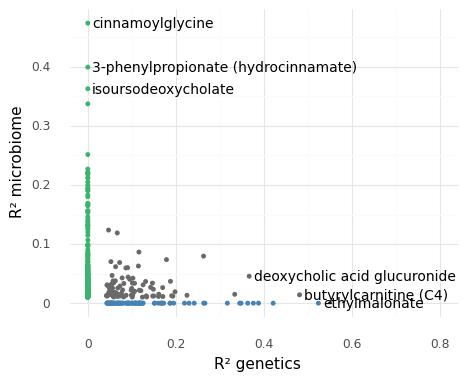

<ggplot: (8782806337407)>

In [88]:
from plotnine import *
from mizani.formatters import percent_format

pl = (
    ggplot(joint_r_sq, aes(x="geno_r2", y="micro_r2", color="group"))
    + geom_point(size=2, stroke=0)
    + geom_text(
        aes(label="BIOCHEMICAL_NAME"), 
        data=joint_r_sq[
            ((joint_r_sq.total > 0.35) & (joint_r_sq.group == "hybrid")) 
            | (joint_r_sq.micro_r2 > 0.35) 
            | (joint_r_sq.geno_r2 > 0.5)], 
        ha="left", nudge_x=0.01, size=10, color="black")
    + theme_minimal()
    + theme(figure_size=(5,4))
    + xlim(0, 0.8)
    + scale_color_manual(values={"genetics": "steelblue", "microbiome": "mediumseagreen", "hybrid": "dimgray"})
    + labs(x="R² genetics", y="R² microbiome") + guides(color=None)
)
pl.save("figures/train_r2.pdf", width=6, height=4)
pl

And we can also look at the most prevalent metabolites.

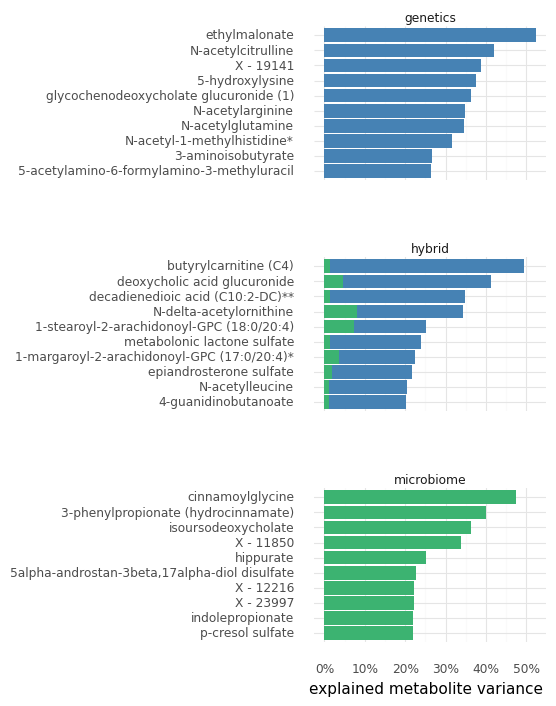

<ggplot: (8782806347397)>

In [89]:
pl = (
    ggplot(long[(long.r2 > 0.0) & (long.metabolite.isin(top))].sort_values(by="r2"), aes(y="r2", x="BIOCHEMICAL_NAME", fill="type"))
    + geom_bar(stat="identity") 
    + scale_y_continuous(labels=percent_format())
    + coord_flip()
    + facet_wrap("~ group", scales="free_y", ncol=1)
    + labs(y = "explained metabolite variance", x="")
    + scale_fill_manual(values=["steelblue", "mediumseagreen"])
    + guides(fill = None)
    + theme_minimal() 
    + theme(figure_size=(3, 8), subplots_adjust={"hspace": 0.5})
)
pl.save("figures/train_specific_r2.pdf", width=3, height=6)
pl

And we can ask what fractions of metabolites fall into each group.

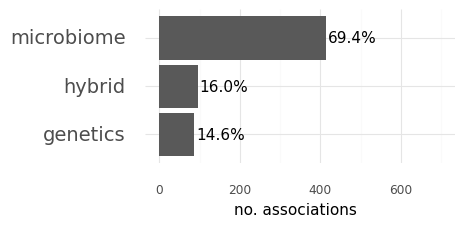

<ggplot: (8782750158836)>

In [90]:
pl = (
    ggplot(joint_r_sq, aes(x="group"))
    + geom_bar() 
    + theme_minimal()
    + theme(figure_size=(4, 2), axis_text_y = element_text(size=14))
    + ylim(0, 700)
    + labs(x="", y="no. associations")
    + geom_text(
     aes(label=after_stat('prop*100'), group=1),
     stat='count',
     nudge_y=5.0,
     va='center',
     ha="left",
     format_string='{:.1f}%'
     )
    + coord_flip()
  
)
pl.save("figures/train_type_fractions.pdf", width=4, height=2)
pl

## Feature overlap

An additional check we can run is whether the genetic and microbiome variance components have any overlap. For that we run joined models for all hybrid metabolites and will track the variance explained by the joint model as well.

In [109]:
hybrids = joint_r_sq.metabolite[joint_r_sq.group == "hybrid"]

combined_r2 = []
combined_fits = {}
for met in track(hybrids):
    snps = sig_snps.SNP[sig_snps.metabolite == met] #.str.split(";").str[0]
    snp_terms = ["Q('%s')" % s for s in snps]
    geno = pd.DataFrame({s: genotypes.get_geno_marker(s) for s in snps}, index=genome_ids)
    mics = sig_microbes.taxon[sig_microbes.metabolite == met]
    mterms = ["Q('%s')" % m for m in mics]
    df = pd.merge(metabolites[["genome_id", "stool_sample_id", met]], geno, left_on="genome_id", right_index=True)
    df = pd.merge(df, metabolites_and_microbes[["stool_sample_id"] + mics.to_list()], on="stool_sample_id")
    formula = f"{met} ~ {' + '.join(snp_terms + mterms)}"
    fit = smf.ols(formula, data=df).fit()
    metrics = pd.DataFrame({
        "metabolite": met,
        "n_taxa": len(mics),
        "combined_r2": fit.rsquared,
        "joint_f": fit.fvalue,
        "joint_p": fit.f_pvalue
    }, index=[met])
    combined_r2.append(metrics)
    combined_fits[met] = fit
combined_r2 = pd.concat(combined_r2)
with open("data/train_combined_fits.pkl", "wb") as out:
    pickle.dump(combined_fits, out)
combined_r2["joint_q"] = fdrcorrection(combined_r2.joint_p)[1]

Output()

In [110]:
combined_r2 = pd.merge(combined_r2, joint_r_sq.reset_index(drop=True), on="metabolite")
combined_r2 = combined_r2[~combined_r2.BIOCHEMICAL_NAME.str.startswith("X -")].reset_index()

In [111]:
combined_r2['additive_tick_loc'] = combined_r2.index.values*2 + 0.375
combined_r2['joint_tick_loc'] = combined_r2.index.values*2 + 1.125
combined_r2['lable_tick_loc'] = combined_r2.index.values*2 + 0.75

And let's visualize the difference between the joint and individual models.

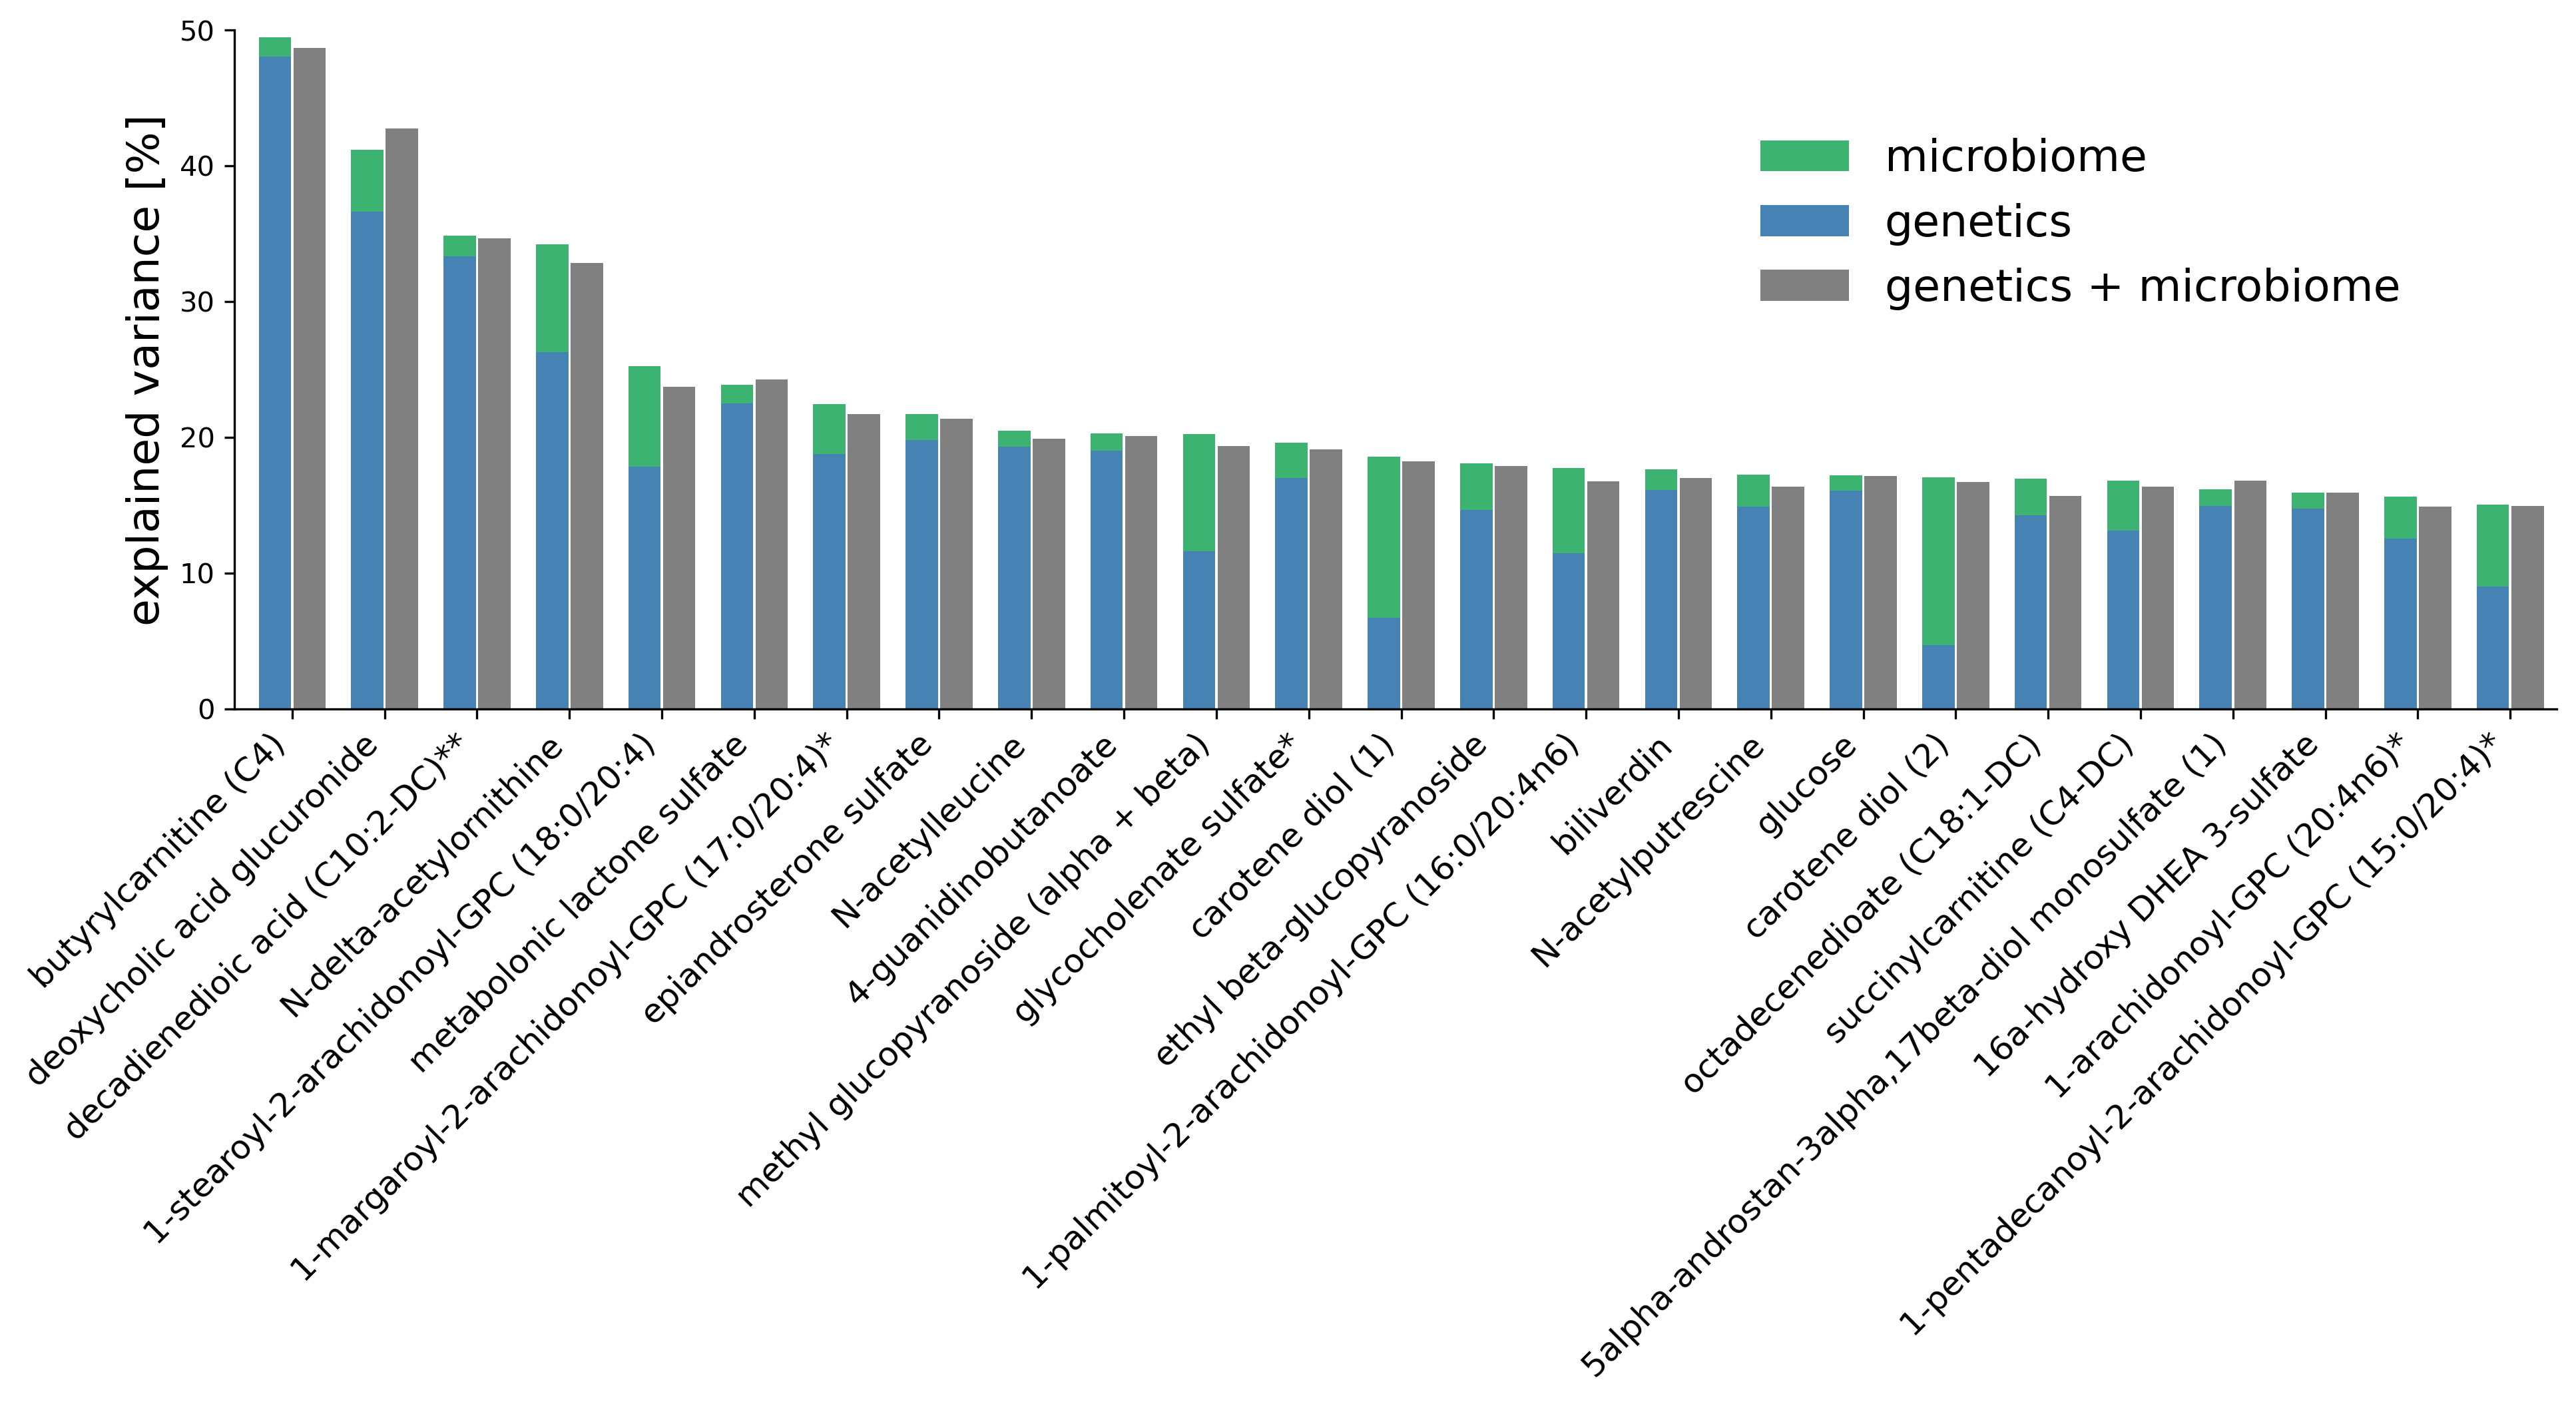

In [112]:
import matplotlib.pyplot as plt
import numpy
import seaborn as sns

cutoff = 25
range_max = int(numpy.round(combined_r2['combined_r2'].max(), 1) * 100)

joint_subset = combined_r2.iloc[:cutoff,:]

fig = plt.figure(figsize=(15, 4.5), dpi = 300)
ax = plt.subplot()
ax.bar(joint_subset["additive_tick_loc"], joint_subset["total"], width=0.7,
            label="microbiome", color="mediumseagreen")
ax.bar(joint_subset["additive_tick_loc"], joint_subset["geno_r2"],width=0.7,
            label="genetics", color="steelblue")
ax.bar(joint_subset["joint_tick_loc"], joint_subset["combined_r2"],width=0.7,
            label="genetics + microbiome", color="grey")
sns.despine()
ax.set_ylim([0,range_max/100])
ax.set_xlim([-0.5,max(joint_subset['lable_tick_loc'].values) + 1])
ax.set_yticklabels(list(range(0,range_max + 10,10)), fontdict={'size':10})
ax.set_xticks((joint_subset['lable_tick_loc'].values))
ax.set_xticklabels(joint_subset['BIOCHEMICAL_NAME'], fontdict={'size':12}, rotation = 45, ha = 'right')
ax.set_ylabel('explained variance [%]', fontdict={'size':16})
ax.set_xlabel('')
ax.legend(bbox_to_anchor = (0.95, 0.9), frameon=False, prop={'size': 16})
plt.savefig("figures/train_hybrid_r2.pdf", pad_inches=0.1, bbox_inches="tight")
plt.show()
plt.close()

And we can look for significant overlap.

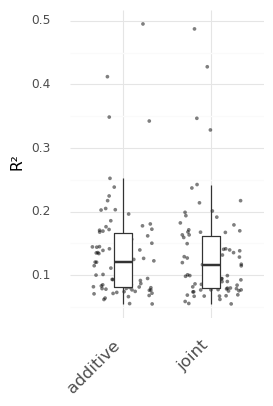

<ggplot: (8782806374708)>

In [113]:
model_comp = combined_r2[["BIOCHEMICAL_NAME", "total", "combined_r2"]].rename(columns={"total": "additive", "combined_r2": "joint"}).melt(id_vars="BIOCHEMICAL_NAME", var_name="type", value_name="r2")
pl = (
    ggplot(model_comp, aes(x="type", y="r2"))
    + geom_jitter(height=0, width=0.35, alpha=0.5, stroke=0)
    + geom_boxplot(width=0.2, outlier_color="none")
    + theme_minimal()
    + labs(x="", y="R²")
    + theme(figure_size=(2.5, 4), axis_text_x = element_text(angle=45, ha="right", va="top", size=12))
)
pl.save("figures/train_r2_overlap.pdf", width=2.5, height=4)
pl

In [114]:
from scipy.stats import wilcoxon

print((combined_r2.total - combined_r2.combined_r2).describe())
wilcoxon(combined_r2.total, combined_r2.combined_r2)

count    82.000000
mean      0.002751
std       0.004560
min      -0.015566
25%       0.000028
50%       0.003114
75%       0.004972
max       0.015167
dtype: float64


WilcoxonResult(statistic=564.0, pvalue=1.4516632932334675e-07)